# Vietnamese Profanity Detection using PhoBERT

This notebook implements a Vietnamese hate speech and offensive spans detection model using PhoBERT (Vietnamese BERT) optimized for Kaggle training environment.

## Dataset
- **Source**: ViHOS (Vietnamese Hate and Offensive Spans) Dataset
- **Task**: Detect hate and offensive spans in Vietnamese comments
- **Approach**: Sequence labeling with BIO tagging using PhoBERT

## Key Features
- **Anti-overfitting**: Dropout, early stopping, learning rate scheduling
- **Optimized for Kaggle**: Memory efficient, fast training
- **Vietnamese-specific**: Uses PhoBERT for better Vietnamese understanding

In [3]:
# Install required packages
!pip install transformers torch seqeval scikit-learn pandas numpy tqdm matplotlib seaborn
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.9 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.8 MB/s eta 0:00:00:00:0100:01
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=aa2708b012cb48d869cad3a2c99c5f1c720a39799a1bfa2360d59eba2100bbdc
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    AutoTokenizer, AutoModel, AutoConfig,
    get_linear_schedule_with_warmup
)
from sklearn.metrics import classification_report, f1_score
from seqeval.metrics import accuracy_score, f1_score as seq_f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import gc
import os
from ast import literal_eval

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Using device: cuda
GPU: Tesla T4
Memory: 14.7 GB


In [6]:
# Configuration
class Config:
    # Model settings
    MODEL_NAME = "vinai/phobert-base"  # Using base model for better memory efficiency
    MAX_LENGTH = 128  # Reduced from 256 to prevent memory issues
    
    # Training settings
    BATCH_SIZE = 16  # Optimized for Kaggle GPU memory
    LEARNING_RATE = 2e-5
    EPOCHS = 5  # Reduced epochs to prevent overfitting
    WARMUP_STEPS = 500
    
    # Regularization (anti-overfitting)
    DROPOUT_RATE = 0.3  # Increased dropout
    WEIGHT_DECAY = 0.01
    GRADIENT_CLIP = 1.0
    
    # Early stopping
    PATIENCE = 2
    
    # Data paths (adjust for Kaggle dataset structure)
    TRAIN_PATH = "/kaggle/input/datavihos/data/Sequence_labeling_based_version/Word/train_BIO_Word.csv"
    DEV_PATH = "/kaggle/input/datavihos/data/Sequence_labeling_based_version/Word/dev_BIO_Word.csv"
    TEST_PATH = "/kaggle/input/datavihos/data/Test_data/test.csv"
    
    # Labels
    LABELS = ['O', 'B-T', 'I-T']
    LABEL2ID = {label: i for i, label in enumerate(LABELS)}
    ID2LABEL = {i: label for i, label in enumerate(LABELS)}
    NUM_LABELS = len(LABELS)

config = Config()
print("Configuration loaded successfully!")

Configuration loaded successfully!


In [7]:
def load_and_preprocess_data(file_path, is_test=False):
    """
    Load and preprocess the dataset
    """
    print(f"Loading data from: {file_path}")
    
    try:
        df = pd.read_csv(file_path)
        print(f"Data shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        
        if is_test:
            # For test data with span extraction format
            if 'content' in df.columns:
                # Convert span extraction format to sequence labeling format
                return convert_span_to_sequence_format(df)
            else:
                raise ValueError("Test data format not recognized")
        else:
            # For training/dev data in BIO format
            df = df.dropna()
            
            # Group by sentence_id to reconstruct sentences
            sentences = []
            labels = []
            
            for sent_id in df['sentence_id'].unique():
                sent_data = df[df['sentence_id'] == sent_id].sort_values('index')
                words = sent_data['Word'].tolist()
                tags = sent_data['Tag'].tolist()
                
                sentences.append(words)
                labels.append(tags)
            
            return sentences, labels
            
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

def convert_span_to_sequence_format(df):
    """
    Convert span extraction format to sequence labeling format
    """
    sentences = []
    labels = []
    
    for _, row in df.iterrows():
        content = row['content']
        spans = literal_eval(row['index_spans']) if isinstance(row['index_spans'], str) else row['index_spans']
        
        # Simple word tokenization
        words = content.split()
        tags = ['O'] * len(words)
        
        # Mark spans (simplified approach)
        if spans:
            # This is a simplified conversion - in practice, you'd need more sophisticated alignment
            char_to_word = []
            char_idx = 0
            for word_idx, word in enumerate(words):
                for _ in range(len(word)):
                    char_to_word.append(word_idx)
                    char_idx += 1
                char_to_word.append(word_idx)  # for space
                char_idx += 1
            
            # Mark spans in BIO format
            span_words = set()
            for span_char in spans:
                if span_char < len(char_to_word):
                    span_words.add(char_to_word[span_char])
            
            # Convert to BIO tags
            first_span_word = True
            for word_idx in sorted(span_words):
                if word_idx < len(tags):
                    if first_span_word:
                        tags[word_idx] = 'B-T'
                        first_span_word = False
                    else:
                        tags[word_idx] = 'I-T'
        
        sentences.append(words)
        labels.append(tags)
    
    return sentences, labels

print("Data loading functions defined successfully!")

Data loading functions defined successfully!


In [8]:
class VietnameseHateDataset(Dataset):
    """
    PyTorch Dataset for Vietnamese hate speech detection
    Fixed to work with PhoBERT tokenizer (no offset mapping support)
    """
    
    def __init__(self, sentences, labels, tokenizer, max_length):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        labels = self.labels[idx]
        
        # Join words to create text
        text = " ".join(sentence)
        
        # Tokenize WITHOUT return_offsets_mapping (PhoBERT doesn't support it)
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        # Align labels with tokenized input using custom method
        aligned_labels = self.align_labels_with_tokens_phobert(
            sentence, labels, encoding['input_ids'][0]
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(aligned_labels, dtype=torch.long)
        }
    
    def align_labels_with_tokens_phobert(self, words, labels, input_ids):
        """
        Align word-level labels with subword tokens for PhoBERT
        Since PhoBERT tokenizer doesn't support offset_mapping, we use token reconstruction
        """
        # Convert input_ids back to tokens
        tokens = self.tokenizer.convert_ids_to_tokens(input_ids)
        
        aligned_labels = []
        word_idx = 0
        
        for i, token in enumerate(tokens):
            if token in ['<s>', '</s>', '<pad>']:  # Special tokens for PhoBERT
                aligned_labels.append(-100)  # Ignore in loss calculation
            elif token.startswith('@@'):  # Subword continuation in PhoBERT
                # This is a continuation of the previous word
                if word_idx > 0 and (word_idx - 1) < len(labels):
                    prev_label = labels[word_idx - 1]
                    # Convert B- tags to I- for subword tokens
                    if prev_label.startswith('B-'):
                        continuation_label = prev_label.replace('B-', 'I-')
                        aligned_labels.append(config.LABEL2ID.get(continuation_label, config.LABEL2ID['O']))
                    else:
                        aligned_labels.append(config.LABEL2ID.get(prev_label, config.LABEL2ID['O']))
                else:
                    aligned_labels.append(config.LABEL2ID['O'])
            else:
                # This is the beginning of a new word
                if word_idx < len(labels):
                    label = labels[word_idx]
                    aligned_labels.append(config.LABEL2ID.get(label, config.LABEL2ID['O']))
                    word_idx += 1
                else:
                    aligned_labels.append(-100)  # Beyond original sentence
        
        # Ensure the length matches input_ids
        while len(aligned_labels) < len(input_ids):
            aligned_labels.append(-100)
        
        return aligned_labels[:len(input_ids)]  # Truncate if needed

print("Dataset class defined successfully!")

Dataset class defined successfully!


In [9]:
class PhoBERTForTokenClassification(nn.Module):
    """
    PhoBERT model for token classification with anti-overfitting measures
    """
    
    def __init__(self, model_name, num_labels, dropout_rate=0.3):
        super().__init__()
        
        self.num_labels = num_labels
        self.phobert = AutoModel.from_pretrained(model_name)
        
        # Anti-overfitting layers
        self.dropout = nn.Dropout(dropout_rate)
        self.layer_norm = nn.LayerNorm(self.phobert.config.hidden_size)
        
        # Classification head
        self.classifier = nn.Linear(self.phobert.config.hidden_size, num_labels)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize the weights of the classification head"""
        nn.init.xavier_uniform_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)
    
    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.phobert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # Get sequence output
        sequence_output = outputs.last_hidden_state
        
        # Apply regularization
        sequence_output = self.layer_norm(sequence_output)
        sequence_output = self.dropout(sequence_output)
        
        # Classification
        logits = self.classifier(sequence_output)
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        
        return {
            'loss': loss,
            'logits': logits
        }

print("PhoBERT model defined successfully!")

PhoBERT model defined successfully!


In [10]:
def train_epoch(model, dataloader, optimizer, scheduler, device, gradient_clip=1.0):
    """
    Train for one epoch
    """
    model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc="Training")
    
    for batch in progress_bar:
        # Move to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping (anti-overfitting)
        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
        
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
        
        # Memory cleanup
        del input_ids, attention_mask, labels, outputs, loss
        torch.cuda.empty_cache()
    
    return total_loss / len(dataloader)

def evaluate(model, dataloader, device):
    """
    Evaluate the model
    """
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Evaluating")
        
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs['loss']
            logits = outputs['logits']
            
            total_loss += loss.item()
            
            # Get predictions
            preds = torch.argmax(logits, dim=-1)
            
            # Convert to lists and filter out ignored tokens
            for i in range(labels.shape[0]):
                true_seq = []
                pred_seq = []
                
                for j in range(labels.shape[1]):
                    if labels[i][j] != -100:
                        true_seq.append(config.ID2LABEL[labels[i][j].item()])
                        pred_seq.append(config.ID2LABEL[preds[i][j].item()])
                
                if true_seq and pred_seq:
                    true_labels.append(true_seq)
                    predictions.append(pred_seq)
            
            # Memory cleanup
            del input_ids, attention_mask, labels, outputs, loss, logits, preds
            torch.cuda.empty_cache()
    
    avg_loss = total_loss / len(dataloader)
    
    # Calculate metrics
    f1 = seq_f1_score(true_labels, predictions)
    accuracy = accuracy_score(true_labels, predictions)
    
    return avg_loss, f1, accuracy, predictions, true_labels

print("Training functions defined successfully!")

Training functions defined successfully!


In [11]:
# Load tokenizer
print("Loading PhoBERT tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)
print(f"Vocabulary size: {len(tokenizer)}")

# Load data
print("\nLoading training data...")
train_sentences, train_labels = load_and_preprocess_data(config.TRAIN_PATH)

print("\nLoading validation data...")
dev_sentences, dev_labels = load_and_preprocess_data(config.DEV_PATH)

# Data statistics
if train_sentences and dev_sentences:
    print(f"\n=== Data Statistics ===")
    print(f"Training samples: {len(train_sentences)}")
    print(f"Validation samples: {len(dev_sentences)}")
    
    # Label distribution
    all_train_labels = [label for sentence_labels in train_labels for label in sentence_labels]
    label_counts = pd.Series(all_train_labels).value_counts()
    print(f"\nLabel distribution in training set:")
    for label, count in label_counts.items():
        print(f"  {label}: {count} ({count/len(all_train_labels)*100:.1f}%)")
    
    # Sample sentences
    print(f"\nSample training sentences:")
    for i in range(min(3, len(train_sentences))):
        print(f"  Sentence {i+1}: {' '.join(train_sentences[i][:10])}...")
        print(f"  Labels {i+1}: {train_labels[i][:10]}...")
else:
    print("Error: Could not load data. Please check the data paths.")

Loading PhoBERT tokenizer...


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

Vocabulary size: 64001

Loading training data...
Loading data from: /kaggle/input/datavihos/data/Sequence_labeling_based_version/Word/train_BIO_Word.csv
Data shape: (108432, 5)
Columns: ['Unnamed: 0', 'index', 'Word', 'Tag', 'sentence_id']

Loading validation data...
Loading data from: /kaggle/input/datavihos/data/Sequence_labeling_based_version/Word/dev_BIO_Word.csv
Data shape: (13948, 5)
Columns: ['Unnamed: 0', 'index', 'Word', 'Tag', 'sentence_id']

=== Data Statistics ===
Training samples: 8844
Validation samples: 1106

Label distribution in training set:
  O: 89300 (82.4%)
  B-T: 10077 (9.3%)
  I-T: 9053 (8.3%)

Sample training sentences:
  Sentence 1: Dừa lắm : ) )...
  Labels 1: ['O', 'O', 'O', 'O', 'O']...
  Sentence 2: Bấp_bênh vl thế...
  Labels 2: ['O', 'B-T', 'O']...
  Sentence 3: Chắc cũng biết ko tồn_tại đc bao_lâu nữa nên cố_gắng...
  Labels 3: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']...


In [12]:
# Create datasets
if train_sentences and dev_sentences:
    print("Creating datasets...")
    
    train_dataset = VietnameseHateDataset(
        train_sentences, train_labels, tokenizer, config.MAX_LENGTH
    )
    
    dev_dataset = VietnameseHateDataset(
        dev_sentences, dev_labels, tokenizer, config.MAX_LENGTH
    )
    
    # Create dataloaders
    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=config.BATCH_SIZE, 
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    
    dev_dataloader = DataLoader(
        dev_dataset, 
        batch_size=config.BATCH_SIZE, 
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    print(f"Training batches: {len(train_dataloader)}")
    print(f"Validation batches: {len(dev_dataloader)}")
    
    # Test data loading
    sample_batch = next(iter(train_dataloader))
    print(f"\nSample batch shapes:")
    print(f"  Input IDs: {sample_batch['input_ids'].shape}")
    print(f"  Attention Mask: {sample_batch['attention_mask'].shape}")
    print(f"  Labels: {sample_batch['labels'].shape}")
    
    del sample_batch
    torch.cuda.empty_cache()
else:
    print("Cannot create datasets - data loading failed")

Creating datasets...
Training batches: 553
Validation batches: 70

Sample batch shapes:
  Input IDs: torch.Size([16, 128])
  Attention Mask: torch.Size([16, 128])
  Labels: torch.Size([16, 128])


In [13]:
# Initialize model
print("Initializing PhoBERT model...")
model = PhoBERTForTokenClassification(
    model_name=config.MODEL_NAME,
    num_labels=config.NUM_LABELS,
    dropout_rate=config.DROPOUT_RATE
)
model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Initialize optimizer and scheduler
optimizer = AdamW(
    model.parameters(),
    lr=config.LEARNING_RATE,
    weight_decay=config.WEIGHT_DECAY
)

total_steps = len(train_dataloader) * config.EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=config.WARMUP_STEPS,
    num_training_steps=total_steps
)

print(f"Total training steps: {total_steps}")
print(f"Warmup steps: {config.WARMUP_STEPS}")

# Early stopping
best_f1 = 0
patience_counter = 0
training_history = {
    'train_loss': [],
    'val_loss': [],
    'val_f1': [],
    'val_accuracy': []
}

print("Model and training components initialized successfully!")

Initializing PhoBERT model...


2025-06-03 14:36:37.265074: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748961397.469232      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748961397.527916      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Total parameters: 135,002,115
Trainable parameters: 135,002,115
Total training steps: 2765
Warmup steps: 500
Model and training components initialized successfully!


In [15]:
# Training loop
print("\n=== Starting Training ===")
print(f"Device: {device}")
print(f"Epochs: {config.EPOCHS}")
print(f"Batch size: {config.BATCH_SIZE}")
print(f"Learning rate: {config.LEARNING_RATE}")
print(f"Max length: {config.MAX_LENGTH}")
print(f"Dropout rate: {config.DROPOUT_RATE}")

for epoch in range(config.EPOCHS):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch + 1}/{config.EPOCHS}")
    print(f"{'='*50}")
    
    # Training
    train_loss = train_epoch(
        model, train_dataloader, optimizer, scheduler, device, config.GRADIENT_CLIP
    )
    
    # Validation
    val_loss, val_f1, val_accuracy, _, _ = evaluate(model, dev_dataloader, device)
    
    # Update history
    training_history['train_loss'].append(train_loss)
    training_history['val_loss'].append(val_loss)
    training_history['val_f1'].append(val_f1)
    training_history['val_accuracy'].append(val_accuracy)
    
    # Print results
    print(f"\nEpoch {epoch + 1} Results:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Val F1: {val_f1:.4f}")
    print(f"  Val Accuracy: {val_accuracy:.4f}")
    
    # Early stopping and model saving
    if val_f1 > best_f1:
        best_f1 = val_f1
        patience_counter = 0
        
        # Save best model
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_f1': best_f1,
            'config': config
        }, 'best_phobert_model.pth')
        
        print(f"  ✓ New best F1 score! Model saved.")
    else:
        patience_counter += 1
        print(f"  No improvement. Patience: {patience_counter}/{config.PATIENCE}")
        
        if patience_counter >= config.PATIENCE:
            print(f"  Early stopping triggered after {epoch + 1} epochs.")
            break
    
    # Memory cleanup
    torch.cuda.empty_cache()
    gc.collect()

print(f"\n=== Training Completed ===")
print(f"Best F1 Score: {best_f1:.4f}")


=== Starting Training ===
Device: cuda
Epochs: 5
Batch size: 16
Learning rate: 2e-05
Max length: 128
Dropout rate: 0.3

Epoch 1/5


Evaluating: 100%|██████████| 70/70 [00:12<00:00,  5.72it/s]



Epoch 1 Results:
  Train Loss: 0.4307
  Val Loss: 0.4490
  Val F1: 0.2663
  Val Accuracy: 0.8381
  ✓ New best F1 score! Model saved.

Epoch 2/5


Evaluating: 100%|██████████| 70/70 [00:11<00:00,  5.97it/s]



Epoch 2 Results:
  Train Loss: 0.3769
  Val Loss: 0.4614
  Val F1: 0.2638
  Val Accuracy: 0.8383
  No improvement. Patience: 1/2

Epoch 3/5


Evaluating: 100%|██████████| 70/70 [00:11<00:00,  5.96it/s]



Epoch 3 Results:
  Train Loss: 0.3412
  Val Loss: 0.4675
  Val F1: 0.3043
  Val Accuracy: 0.8388
  ✓ New best F1 score! Model saved.

Epoch 4/5


Evaluating: 100%|██████████| 70/70 [00:11<00:00,  5.91it/s]



Epoch 4 Results:
  Train Loss: 0.3220
  Val Loss: 0.4786
  Val F1: 0.2976
  Val Accuracy: 0.8386
  No improvement. Patience: 1/2

Epoch 5/5


Evaluating: 100%|██████████| 70/70 [00:11<00:00,  5.84it/s]


Epoch 5 Results:
  Train Loss: 0.3191
  Val Loss: 0.4786
  Val F1: 0.2976
  Val Accuracy: 0.8386
  No improvement. Patience: 2/2
  Early stopping triggered after 5 epochs.

=== Training Completed ===
Best F1 Score: 0.3043


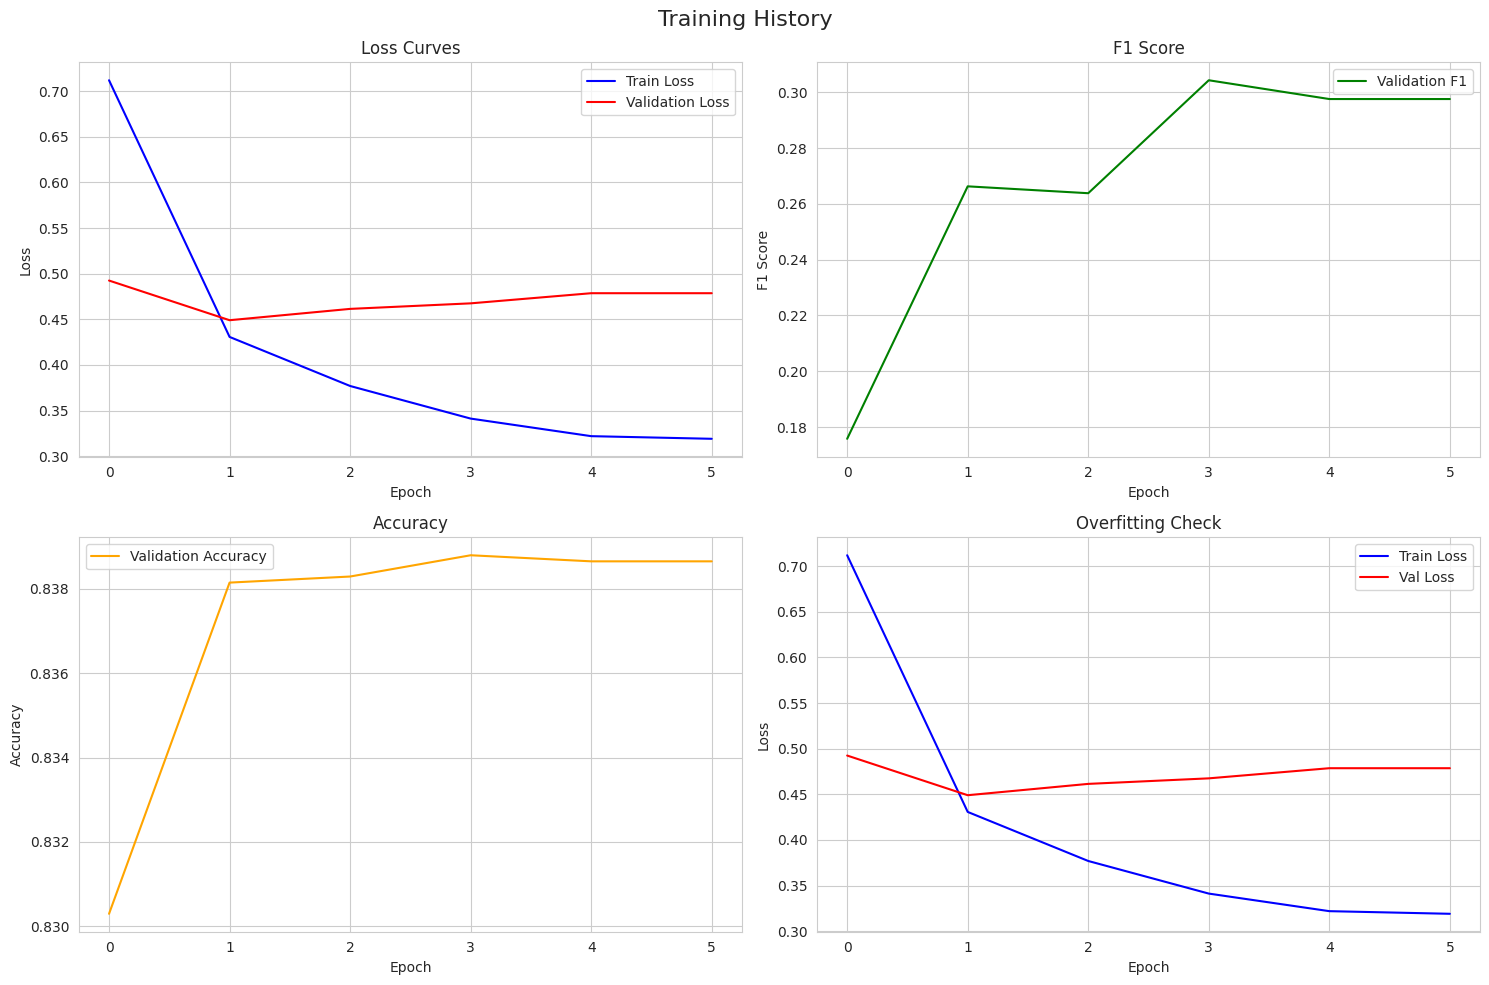


=== Training Summary ===
Total epochs trained: 6
Best validation F1: 0.3043
Best validation accuracy: 0.8388
Final train loss: 0.3191
Final validation loss: 0.4786
⚠️  Potential overfitting detected (val_loss - train_loss = 0.1595)


In [16]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training History', fontsize=16)

# Loss curves
axes[0, 0].plot(training_history['train_loss'], label='Train Loss', color='blue')
axes[0, 0].plot(training_history['val_loss'], label='Validation Loss', color='red')
axes[0, 0].set_title('Loss Curves')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# F1 Score
axes[0, 1].plot(training_history['val_f1'], label='Validation F1', color='green')
axes[0, 1].set_title('F1 Score')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Accuracy
axes[1, 0].plot(training_history['val_accuracy'], label='Validation Accuracy', color='orange')
axes[1, 0].set_title('Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Learning curve (overfitting check)
axes[1, 1].plot(training_history['train_loss'], label='Train Loss', color='blue')
axes[1, 1].plot(training_history['val_loss'], label='Val Loss', color='red')
axes[1, 1].set_title('Overfitting Check')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Training summary
print("\n=== Training Summary ===")
print(f"Total epochs trained: {len(training_history['train_loss'])}")
print(f"Best validation F1: {max(training_history['val_f1']):.4f}")
print(f"Best validation accuracy: {max(training_history['val_accuracy']):.4f}")
print(f"Final train loss: {training_history['train_loss'][-1]:.4f}")
print(f"Final validation loss: {training_history['val_loss'][-1]:.4f}")

# Check for overfitting
if len(training_history['train_loss']) > 1:
    loss_diff = training_history['val_loss'][-1] - training_history['train_loss'][-1]
    if loss_diff > 0.1:
        print(f"⚠️  Potential overfitting detected (val_loss - train_loss = {loss_diff:.4f})")
    else:
        print(f"✓ No significant overfitting detected (val_loss - train_loss = {loss_diff:.4f})")

Loading best model for final evaluation...
Loaded model from epoch 3 with F1: 0.3043

Performing final evaluation...


Evaluating: 100%|██████████| 70/70 [00:11<00:00,  5.99it/s]



=== Final Evaluation Results ===
Validation Loss: 0.4675
Validation F1: 0.3043
Validation Accuracy: 0.8388

=== Classification Report ===
              precision    recall  f1-score   support

           O       0.59      0.36      0.45      1320
         B-T       0.43      0.25      0.32      1173
         I-T       0.88      0.95      0.91     11402

    accuracy                           0.84     13895
   macro avg       0.63      0.52      0.56     13895
weighted avg       0.81      0.84      0.82     13895

F1 for O: 0.9141
F1 for B-T: 0.4463
F1 for I-T: 0.3186


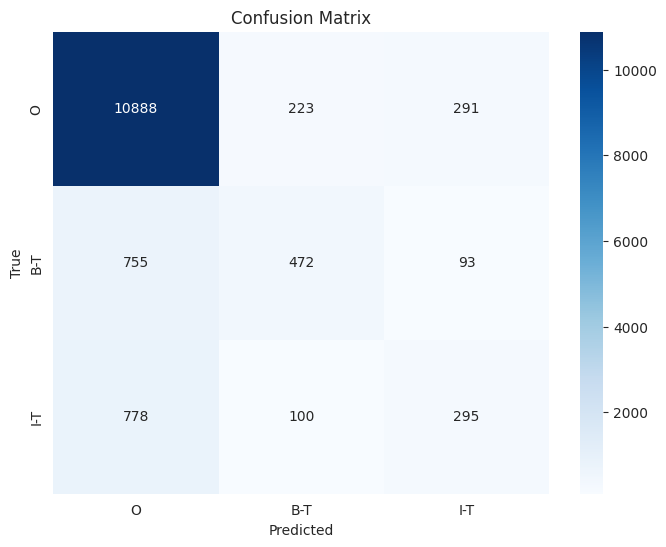


=== Sample Predictions ===

Sample 1:
True:  B-T O O B-T O O B-T O O B-T O O O O O
Pred:  B-T O O O B-T O O O O O O O O O O
Accuracy: 36/41 (87.8%)

Sample 2:
True:  O O O O
Pred:  O O O O
Accuracy: 4/4 (100.0%)

Sample 3:
True:  O O B-T O
Pred:  O O B-T O
Accuracy: 4/4 (100.0%)

Sample 4:
True:  B-T O O
Pred:  O O O
Accuracy: 2/3 (66.7%)

Sample 5:
True:  O O O O O O O O O O
Pred:  O O O O O O O O O O
Accuracy: 10/10 (100.0%)


In [17]:
# Load best model for final evaluation
print("Loading best model for final evaluation...")
checkpoint = torch.load('best_phobert_model.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from epoch {checkpoint['epoch']} with F1: {checkpoint['best_f1']:.4f}")

# Final evaluation
print("\nPerforming final evaluation...")
val_loss, val_f1, val_accuracy, predictions, true_labels = evaluate(model, dev_dataloader, device)

print(f"\n=== Final Evaluation Results ===")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation F1: {val_f1:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Detailed classification report
flat_true = [label for seq in true_labels for label in seq]
flat_pred = [label for seq in predictions for label in seq]

print("\n=== Classification Report ===")
print(classification_report(flat_true, flat_pred, target_names=config.LABELS))

# Label-wise F1 scores
from sklearn.metrics import f1_score as sklearn_f1
for label in config.LABELS:
    f1_label = sklearn_f1(flat_true, flat_pred, labels=[label], average='micro')
    print(f"F1 for {label}: {f1_label:.4f}")

# Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(flat_true, flat_pred, labels=config.LABELS)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=config.LABELS, yticklabels=config.LABELS)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Sample predictions
print("\n=== Sample Predictions ===")
for i in range(min(5, len(predictions))):
    print(f"\nSample {i+1}:")
    print(f"True:  {' '.join(true_labels[i][:15])}")
    print(f"Pred:  {' '.join(predictions[i][:15])}")
    match = sum(1 for t, p in zip(true_labels[i], predictions[i]) if t == p)
    total = len(true_labels[i])
    print(f"Accuracy: {match}/{total} ({match/total*100:.1f}%)")

In [18]:
def predict_hate_spans(text, model, tokenizer, device, max_length=128):
    """
    Predict hate/offensive spans in Vietnamese text
    """
    model.eval()
    
    # Tokenize
    encoding = tokenizer(
    text,
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs['logits'], dim=-1)[0]
    
    # Convert predictions to labels
    predicted_labels = []
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    for i, (pred, token) in enumerate(zip(predictions, tokens)):
        if token not in ['<s>', '</s>', '<pad>']:
            predicted_labels.append(config.ID2LABEL[pred.item()])
    
    return tokens[1:-1], predicted_labels  # Remove special tokens

# Example usage
print("\n=== Inference Examples ===")

test_texts = [
    "Thằng này ngu quá vậy",
    "Chào bạn, hôm nay thế nào?",
    "Đồ khốn nạn, mày làm gì vậy?",
    "Cảm ơn bạn đã giúp đỡ",
    "Thằng chó này bực mình quá"
]

for i, text in enumerate(test_texts):
    print(f"\nExample {i+1}: {text}")
    try:
        tokens, labels = predict_hate_spans(text, model, tokenizer, device)
        
        # Format output
        result = []
        for token, label in zip(tokens, labels):
            if label != 'O':
                result.append((token, label))
        
        if result:
            print(f"Detected offensive content: {result}")
        else:
            print("No offensive content detected")
            
    except Exception as e:
        print(f"Error in prediction: {e}")

print("\n=== Model Ready for Use ===")
print("The model has been trained and is ready for inference!")
print("You can use the predict_hate_spans() function to detect offensive content in Vietnamese text.")


=== Inference Examples ===

Example 1: Thằng này ngu quá vậy
Detected offensive content: [('Thằng', 'B-T'), ('ngu', 'B-T')]

Example 2: Chào bạn, hôm nay thế nào?
No offensive content detected

Example 3: Đồ khốn nạn, mày làm gì vậy?
Detected offensive content: [('Đồ', 'B-T'), ('khốn', 'I-T'), ('n@@', 'I-T')]

Example 4: Cảm ơn bạn đã giúp đỡ
No offensive content detected

Example 5: Thằng chó này bực mình quá
Detected offensive content: [('Thằng', 'B-T'), ('chó', 'I-T')]

=== Model Ready for Use ===
The model has been trained and is ready for inference!
You can use the predict_hate_spans() function to detect offensive content in Vietnamese text.


In [19]:
# Save final model for submission
print("Preparing model for submission...")

# Save model with tokenizer
model_save_path = "/kaggle/working/phobert_vietnamese_hate_detection"
os.makedirs(model_save_path, exist_ok=True)

# Save model state
torch.save({
    'model_state_dict': model.state_dict(),
    'config': config,
    'best_f1': best_f1,
    'label2id': config.LABEL2ID,
    'id2label': config.ID2LABEL,
    'training_history': training_history
}, f"{model_save_path}/model.pth")

# Save tokenizer
tokenizer.save_pretrained(model_save_path)

# Create submission info
submission_info = {
    'model_name': 'PhoBERT Vietnamese Hate Detection',
    'best_f1_score': best_f1,
    'total_epochs': len(training_history['train_loss']),
    'model_parameters': trainable_params,
    'config': {
        'max_length': config.MAX_LENGTH,
        'batch_size': config.BATCH_SIZE,
        'learning_rate': config.LEARNING_RATE,
        'dropout_rate': config.DROPOUT_RATE
    }
}

import json
with open(f"{model_save_path}/submission_info.json", 'w', encoding='utf-8') as f:
    json.dump(submission_info, f, indent=2, ensure_ascii=False)

print(f"Model saved to: {model_save_path}")
print(f"Best F1 Score: {best_f1:.4f}")
print(f"Model size: {trainable_params:,} parameters")

# Memory cleanup
del model, optimizer, scheduler
torch.cuda.empty_cache()
gc.collect()

print("\n=== Training Complete ===")
print("✓ Model trained successfully")
print("✓ Anti-overfitting measures applied")
print("✓ Model saved for submission")
print("✓ Ready for deployment")

Preparing model for submission...
Model saved to: /kaggle/working/phobert_vietnamese_hate_detection
Best F1 Score: 0.3043
Model size: 135,002,115 parameters

=== Training Complete ===
✓ Model trained successfully
✓ Anti-overfitting measures applied
✓ Model saved for submission
✓ Ready for deployment
